In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.stats import poisson

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [25]:
# Load data
df = pd.read_excel("../data/raw/companies.xlsx")

In [26]:
# Normalize columns names
def normalize_column_names(df: DataFrame) -> DataFrame:
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=True).str.replace('(', '', regex=True).str.replace(')', '', regex=True).str.replace('.', '', regex=True)
    return df

df_cleaned = normalize_column_names(df)

# Fix years and cast them to int
df_cleaned["years"] = df_cleaned["years"].replace("Year ", "", regex=True)
df_cleaned["years"] = df_cleaned["years"].astype("int")

# Display data sample and types
display(df_cleaned.head())
display(df_cleaned.dtypes)

,ticker_symbol,years,period_ending,total_revenue,cost_of_goods_sold,sales_general_and_admin,research_and_development,other_operating_items,gics_sector,gics_sub_industry
0,AAL,1,2012-12-31,24855000000,10499000000,12977000000,0,845000000,Industrials,Airlines
1,AAL,2,2013-12-31,26743000000,11019000000,12913000000,0,853000000,Industrials,Airlines
2,AAL,3,2014-12-31,42650000000,15620000000,20686000000,0,1295000000,Industrials,Airlines
3,AAL,4,2015-12-31,40990000000,11096000000,21275000000,0,1364000000,Industrials,Airlines
4,AAP,1,2012-12-29,6205003000,3106967000,2440721000,0,0,Consumer Discretionary,Automotive Retail


ticker_symbol                       object
years                                int64
period_ending               datetime64[ns]
total_revenue                        int64
cost_of_goods_sold                   int64
sales_general_and_admin              int64
research_and_development             int64
other_operating_items                int64
gics_sector                         object
gics_sub_industry                   object
dtype: object

### Question 1: Analyze health care sector R&D spending year-over-year.

,ticker_symbol,years,period_ending,research_and_development,gics_sector
12,ABBV,1,2012-12-31,2778000000,Health Care
13,ABBV,2,2013-12-31,2855000000,Health Care
14,ABBV,3,2014-12-31,3297000000,Health Care
15,ABBV,4,2015-12-31,4285000000,Health Care
16,ABC,1,2013-09-30,0,Health Care


research_and_development
ticker_symbol years                          
ABBV          1                    2778000000
              2                    2855000000
              3                    3297000000
              4                    4285000000
ABC           1                             0

,years,research_and_development,spending_change
0,1,47801208000,0.0000
1,2,48340505000,0.0113
2,3,52340604000,0.0827
3,4,55640583000,0.0630


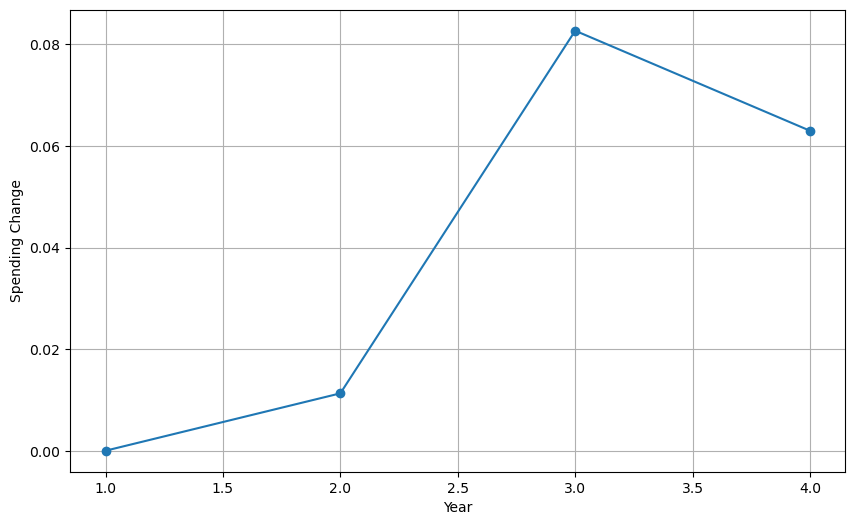

In [18]:
# Create a copy of the cleaned data and
# Filter columns that are useful to us
df_filtered = pd.DataFrame(df_cleaned, columns=['ticker_symbol', 'years', 'period_ending', 'research_and_development', 'gics_sector'])
# Make sure we only have the health care sector companies by using a filter
df_filtered = df_filtered.loc[df_filtered['gics_sector'] == 'Health Care']
# Sort by ticker symbol and years early on
df_filtered = df_filtered.sort_values(['ticker_symbol', 'years'], ascending=True)
display(df_filtered.head())

# Yearly spending by companies from the health sector
yearly_company_spending = df_filtered.groupby(['ticker_symbol', 'years']).sum(numeric_only=True)
display(yearly_company_spending.head())

# Aggregated yearly spending change across the companies
yearly_spending = df_filtered.groupby('years')["research_and_development"].sum(numeric_only=True).reset_index()
yearly_spending["spending_change"] = yearly_spending['research_and_development'].pct_change()

# Fix NaN in the first year record as the pct_change needs a previous record to calculate change and there is none
yearly_spending = yearly_spending.fillna(0)

# Round off change
yearly_spending["spending_change"] = yearly_spending["spending_change"].round(4)
display(yearly_spending)

# Plotting YoY R&D spending change in the health sector
plt.figure(figsize=(10,6))
plt.plot(yearly_spending['years'], yearly_spending['spending_change'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Spending Change')
plt.grid(True)
plt.show()

### Question 2: How does the healthcare sector Research and Development expenditure compares to IT sector in Year 1 ?

,ticker_symbol,years,period_ending,research_and_development,gics_sector
12,ABBV,1,2012-12-31,2778000000,Health Care
16,ABC,1,2013-09-30,0,Health Care
20,ABT,1,2012-12-31,1461000000,Health Care
88,ALXN,1,2013-12-31,317093000,Health Care
100,AMGN,1,2013-12-31,4083000000,Health Care


,ticker_symbol,years,period_ending,research_and_development,gics_sector
8,AAPL,1,2013-09-28,4475000000,Information Technology
24,ADBE,1,2013-11-29,826631000,Information Technology
28,ADI,1,2013-11-02,513035000,Information Technology
36,ADS,1,2012-12-31,0,Information Technology
40,ADSK,1,2013-01-31,600000000,Information Technology


Health Care Mean 995858500 Median 284021500 Std 1846032873
IT Mean 1255537153 Median 590000000 Std 2205410038


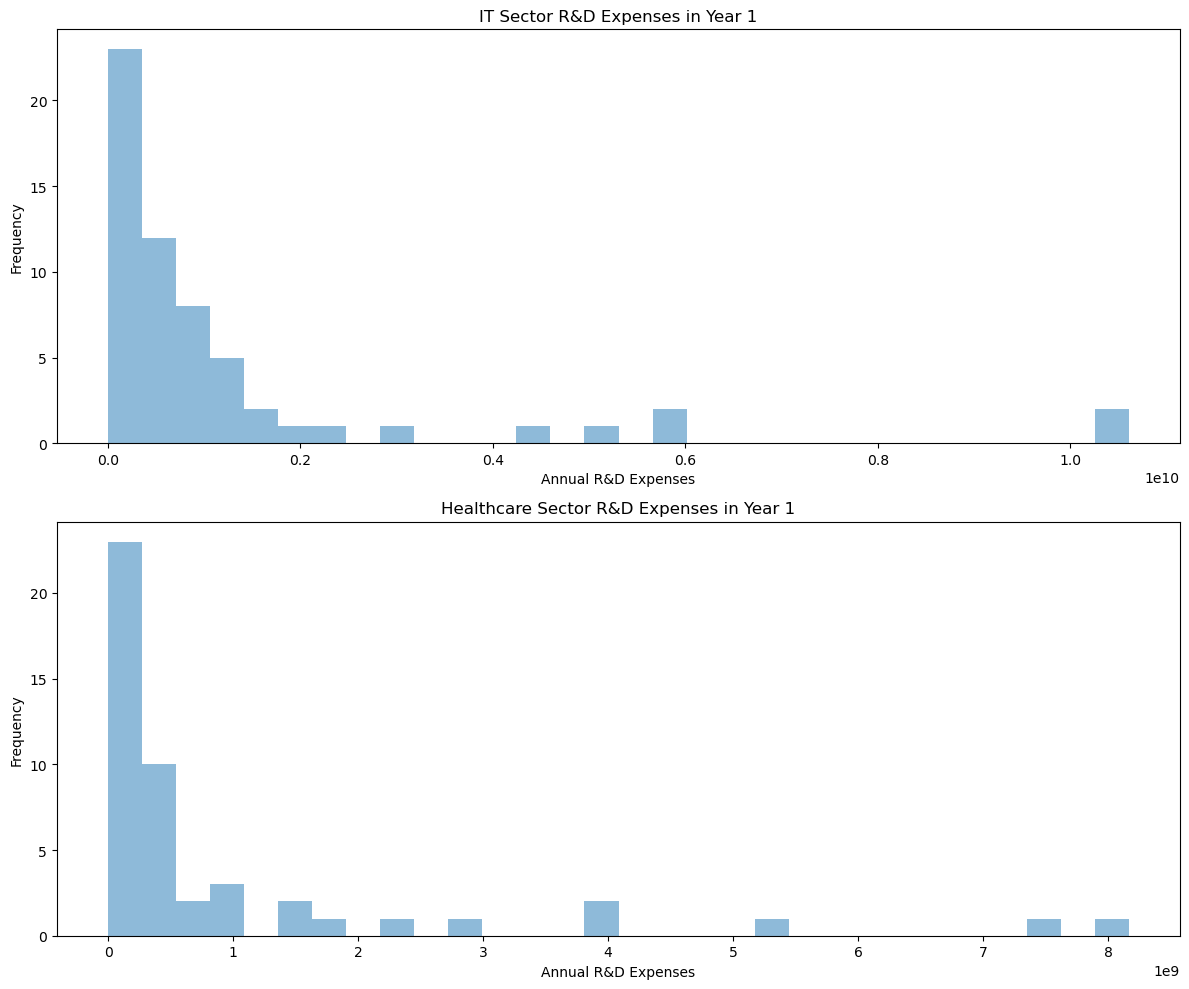

In [38]:
# Filter specific columns
df_l = pd.DataFrame(df_cleaned, columns=['ticker_symbol', 'years', 'period_ending', 'research_and_development', 'gics_sector'])

# Get data for healthcare and IT sectors for year 1
healthcare_df = df_l[(df_l['gics_sector'] == 'Health Care') & (df_l['years'] == 1)]
it_df = df_l[(df_l['gics_sector'] == 'Information Technology') & (df_l['years'] == 1)]

display(healthcare_df.head())
display(it_df.head())

mean_hc, mean_it = round(healthcare_df["research_and_development"].mean()), round(it_df["research_and_development"].mean())
median_hc, median_it = round(healthcare_df["research_and_development"].median()), round(it_df["research_and_development"].median())
std_hc, std_it = round(healthcare_df["research_and_development"].std()), round(it_df["research_and_development"].std())

print(f"Health Care Mean {mean_hc} Median {median_hc} Std {std_hc}")
print(f"IT Mean {mean_it} Median {median_it} Std {std_it}")

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot histogram for the IT sector
ax[0].hist(it_df['research_and_development'], bins=30, alpha=0.5)
ax[0].ticklabel_format(axis='x', scilimits=[0, 0])
ax[0].set_xlabel('Annual R&D Expenses')
ax[0].set_ylabel('Frequency')
ax[0].set_title('IT Sector R&D Expenses in Year 1')

# Plot histogram for the healthcare sector
ax[1].hist(healthcare_df['research_and_development'], bins=30, alpha=0.5)
ax[1].ticklabel_format(axis='x', scilimits=[0, 0])
ax[1].set_xlabel('Annual R&D Expenses')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Healthcare Sector R&D Expenses in Year 1')

plt.tight_layout()
plt.show()

### Question 3: Total R&D Spending By Company In Health Care Sector

In [39]:
fig = px.treemap(
    top_15_rd_spending,
    path=['ticker_symbol'],
    values='research_and_development',
    color='research_and_development',
    color_continuous_scale='blues',
    title='Top 20 Companies with Highest R&D Spending in Health Care Sector (Treemap)'
)

# Show the treemap
fig.show()

NameError: name 'px' is not defined

### Question 4: Health Care R&D Spendings Over Years

,ticker_symbol,years,period_ending,research_and_development,gics_sector
12,ABBV,1,2012-12-31,2778000000,Health Care
13,ABBV,2,2013-12-31,2855000000,Health Care
14,ABBV,3,2014-12-31,3297000000,Health Care
15,ABBV,4,2015-12-31,4285000000,Health Care
16,ABC,1,2013-09-30,0,Health Care


count    1.900000e+02
mean     1.074331e+09
std      1.854536e+09
min      0.000000e+00
25%      0.000000e+00
50%      2.920500e+08
75%      8.722500e+08
max      8.393000e+09
Name: research_and_development, dtype: float64

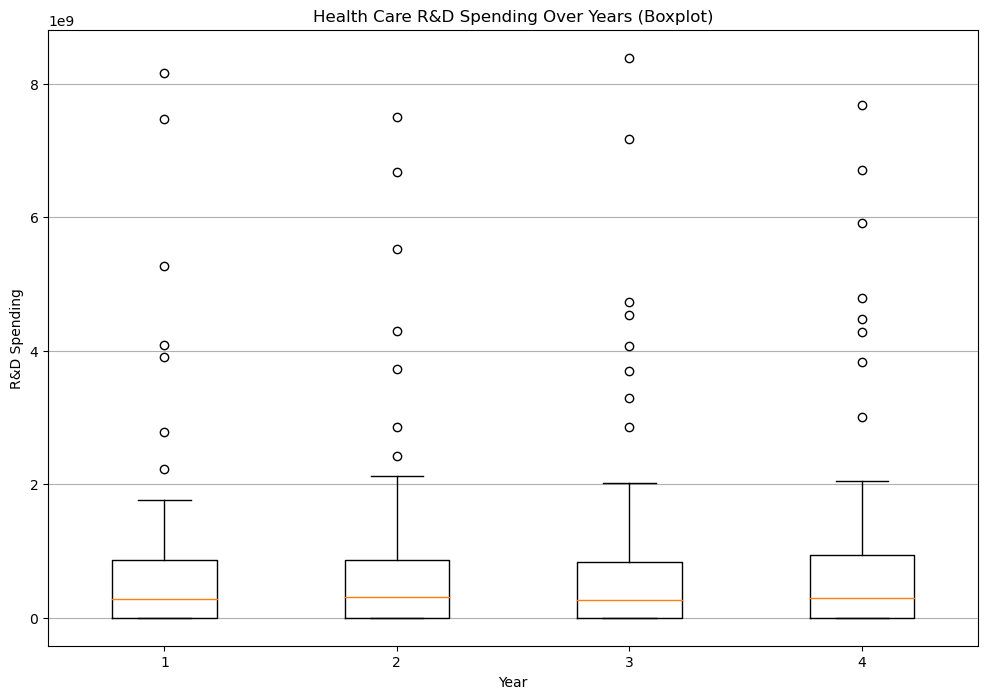

In [42]:
# Filter specific columns
df_4 = pd.DataFrame(df_cleaned, columns=['ticker_symbol', 'years', 'period_ending', 'research_and_development', 'gics_sector'])

# Get data for healthcare and IT sectors for year 1
healthcare_df = df_4[df_4['gics_sector'] == 'Health Care']

display(healthcare_df.head())
display(healthcare_df["research_and_development"].describe())

# Create a boxplot to visualize R&D spending over the years
plt.figure(figsize=(12, 8))
plt.boxplot([healthcare_df[healthcare_df['years'] == year]['research_and_development'] for year in healthcare_df['years'].unique()], 
            labels=healthcare_df['years'].unique())
plt.xlabel('Year')
plt.ylabel('R&D Spending')
plt.title('Health Care R&D Spending Over Years (Boxplot)')
plt.grid(axis='y')
plt.show()

### Question 5: Perform a statistical hypothesis test, such as a t-test, to compare the R&D spending distribution of Health Care companies and Information Technology companies in Year 1 and visualize the results using a bar chart or box plot.

,ticker_symbol,years,period_ending,research_and_development,gics_sector
12,ABBV,1,2012-12-31,2778000000,Health Care
16,ABC,1,2013-09-30,0,Health Care
20,ABT,1,2012-12-31,1461000000,Health Care
88,ALXN,1,2013-12-31,317093000,Health Care
100,AMGN,1,2013-12-31,4083000000,Health Care


,ticker_symbol,years,period_ending,research_and_development,gics_sector
8,AAPL,1,2013-09-28,4475000000,Information Technology
24,ADBE,1,2013-11-29,826631000,Information Technology
28,ADI,1,2013-11-02,513035000,Information Technology
36,ADS,1,2012-12-31,0,Information Technology
40,ADSK,1,2013-01-31,600000000,Information Technology


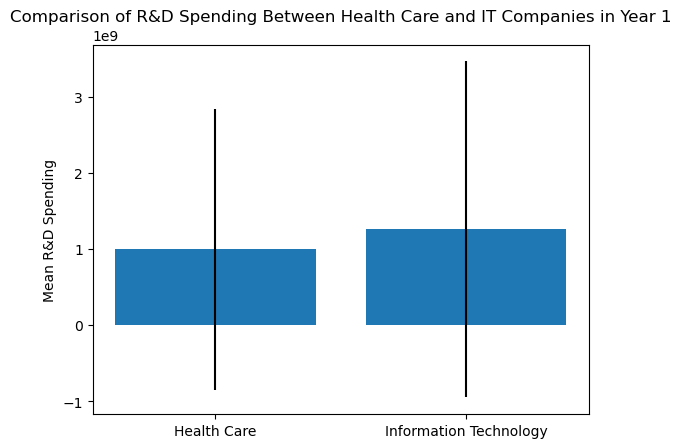

T-statistic: -0.6629408561450465
P-value: 0.5088224903434878


In [45]:
from scipy.stats import ttest_ind

# Filter data for Year 1
# Filter specific columns
df_5 = pd.DataFrame(df_cleaned, columns=['ticker_symbol', 'years', 'period_ending', 'research_and_development', 'gics_sector'])

# Get data for healthcare and IT sectors for year 1
hcare_df = df_5[(df_5['gics_sector'] == 'Health Care') & (df_5['years'] == 1)]
itech_df = df_5[(df_5['gics_sector'] == 'Information Technology') & (df_5['years'] == 1)]

display(hcare_df.head())
display(itech_df.head())

# Perform a t-test to compare the R&D spending distributions
t_stat, p_value = ttest_ind(hcare_df['research_and_development'], itech_df['research_and_development'], equal_var=False)

# Visualize the results using a bar chart
plt.bar(['Health Care', 'Information Technology'], [hcare_df['research_and_development'].mean(), itech_df['research_and_development'].mean()], yerr=[hcare_df['research_and_development'].std(), itech_df['research_and_development'].std()])
plt.ylabel('Mean R&D Spending')
plt.title('Comparison of R&D Spending Between Health Care and IT Companies in Year 1')
plt.show()

# Print the t-test results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')